In [1]:
import xarray as xr
import numpy  as np
# import seaborn as sns
import proplot as pplt
import pandas as pd
import matplotlib.pyplot as plt

# 数据读入 + 预处理diurnal部分
2021.12.26

添加diurnal部分，进行日变化序列的分析，拆分到两个季节以及不同的子区域上。

因为逐小时数据量较大，在前半部分数据需要进行预处理，先处理出逐小时的3D数组，存放后进行后半部分的绘图。

临时数据存放在 ./nc_output/ 下

RCM和VR足够相似，LBCs对于diurnal的改善效果较小。



## 数据预处理

### CMORPH v1.0 30km 8mins

In [ ]:
path_in = "/raid52/yycheng/MPAS/REFERENCE/CMORPH/CMORPHv1.0ADJ_30mins_8km/CMORPH_hourly_1998-2017/"
ds_cmorph = xr.open_mfdataset(path_in + "CMORPH*.nc")

In [ ]:
temp_da = ds_cmorph['cmorph'][:,0,:,:].load()
time_seasonal_ind = {}
time_seasonal_ind['am'] = temp_da.time.dt.month.isin([4,5])
time_seasonal_ind['jja'] = temp_da.time.dt.month.isin([6,7,8])

da_out = {}
for season in ['am', 'jja']:
    temp_seasonal = temp_da.isel(time = time_seasonal_ind[season])
    # 计算diurnal序列 3D
    temp_seasonal = temp_seasonal.groupby(temp_seasonal.time.dt.hour).mean()
    da_out[season] = temp_seasonal
    del(temp_seasonal)

In [ ]:
xr.Dataset(da_out).rename({"am":"cmorph_am","jja":"cmorph_jja"}).to_netcdf("./output_nc/cmorph_diurnal.nc")

### MPAS VR & RCM cases

In [ ]:
mod_type = "RCM"
path_in = "/raid52/yycheng/MPAS/"+mod_type+"_postprocess/"+mod_type+"_merge_large/pre_hourly/"
ds_temp = xr.open_mfdataset(path_in + "merge_pre_????_*.nc")

In [ ]:
ds_temp
time_seasonal_ind = {}
time_seasonal_ind['am'] = ds_temp.Time.dt.month.isin([4,5])
time_seasonal_ind['jja'] = ds_temp.Time.dt.month.isin([6,7,8])

ds_out = {}
for season in ['am', 'jja']:
    temp_seasonal = ds_temp.isel(Time = time_seasonal_ind[season])
    temp_seasonal = temp_seasonal.groupby(temp_seasonal.Time.dt.hour).mean()
    ds_out[season] = temp_seasonal
    ds_out[season].to_netcdf("./output_nc/" + mod_type + "_" + season +"_diurnal.nc")

## 整理计算部分
拆分到不同的子区域

In [2]:
ds_in = {}
for season in ['am', 'jja']:
    ds_in[season] = {}
    ds_in[season]['cmorph'] = xr.open_dataset("./output_nc/cmorph_diurnal.nc")["cmorph_"+ season].rename({"lat":"latitude","lon":"longitude"})
    ds_in[season]['vr']     = xr.open_dataset("./output_nc/VR_"+season+"_diurnal.nc")
    ds_in[season]['rcm']    = xr.open_dataset("./output_nc/RCM_"+season+"_diurnal.nc")


In [3]:
select_regions = {}
select_regions['NE'] = {"slat":42. , "nlat":53. , "wlon":114. , "elon": 134}
select_regions['NC'] = {"slat":34. , "nlat":42. , "wlon":107. , "elon": 123.}
select_regions['YZ'] = {"slat":26. , "nlat":34. , "wlon":107. , "elon": 123.}
select_regions['SC'] = {"slat":18. , "nlat":26. , "wlon":107. , "elon": 126.}
select_regions['SW'] = {"slat":22. , "nlat":28. , "wlon":98. , "elon": 107.}
select_regions['NWC'] = {"slat":35. , "nlat":48. , "wlon":77. , "elon": 100.}

ts_regional = {}
for season in ['am', 'jja']:
    ts_regional[season] = {}
    for model in ['cmorph', 'vr', 'rcm']:
        ts_regional[season][model] = {}
        latitude = ds_in[season][model].latitude
        longitude = ds_in[season][model].longitude
        for region in select_regions:
            select_dict_temp = {}
            select_dict_temp['latitude'] = ( latitude >= select_regions[region]['slat'] ) & ( latitude <= select_regions[region]['nlat'] )
            select_dict_temp['longitude'] = ( longitude >= select_regions[region]['wlon'] ) & ( longitude <= select_regions[region]['elon'] )
            ts_regional[season][model][region] = ds_in[season][model].isel(select_dict_temp).mean(dim = ['latitude', 'longitude'])

In [4]:
import skill_metrics as sm
metrics_ts = {}
for season in ['am', 'jja']:
    metrics_ts[season] = {}           
    for region in ["NE", "NC", "NWC", "SC",'SW','YZ']:
        metrics_ts[season][region] = pd.DataFrame(index = ['vr','rcm'], columns=['Bias','RMSE','Corr.'])     
        for model in ['vr', 'rcm']:
            temp_obs = ts_regional[season]['cmorph'][region].values
            temp_mod = ts_regional[season][model][region]['rainc'].values + ts_regional[season][model][region]['rainnc'].values

            metrics_ts[season][region].loc[model]['Bias'] = sm.bias(temp_mod, temp_obs)
            metrics_ts[season][region].loc[model]['RMSE'] = sm.rmsd(temp_mod, temp_obs)
            metrics_ts[season][region].loc[model]['Corr.'] = np.corrcoef(temp_mod, temp_obs)[0,1]
    
metrics_ts
#     # 对style进行调整，用于后续展示表格
#     # https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
#     # metrics_ts[iregion] = metrics_ts[iregion].style.format("{:,.3f}")

{'am': {'NE':           Bias       RMSE     Corr.
  vr   0.0368559  0.0380612  0.257034
  rcm  0.0309815    0.03231  0.273526,
  'NC':           Bias       RMSE     Corr.
  vr   0.0139799  0.0172396 -0.416652
  rcm  0.0136154  0.0172071 -0.543551,
  'NWC':            Bias        RMSE     Corr.
  vr   0.00645438    0.010246  0.166831
  rcm  0.00468173  0.00920049  0.224743,
  'SC':           Bias       RMSE     Corr.
  vr   0.0426629   0.053318  0.392422
  rcm  0.0278459  0.0394883   0.49595,
  'SW':           Bias       RMSE     Corr.
  vr   0.0848786   0.093136 -0.199104
  rcm  0.0697499  0.0792471 -0.196456,
  'YZ':           Bias       RMSE     Corr.
  vr   0.0604271  0.0628262  0.783125
  rcm  0.0600033  0.0631818  0.427364},
 'jja': {'NE':           Bias       RMSE     Corr.
  vr   0.0444633  0.0545196   0.17105
  rcm  0.0485023  0.0584491  0.232935,
  'NC':           Bias       RMSE     Corr.
  vr   0.0476869  0.0656582 -0.583605
  rcm  0.0290064  0.0481936 -0.653062,
  'NWC':   

## 绘图部分
注意时间坐标需要从UTC转化到Shanghai时间（作为本地时间的参考），shanghai时间 0 - 23 时 是 UTC 15-23...0-14 时

In [5]:
# 绘制时间在北京时间的 00 - 23 
BJT_hour = pd.date_range("1998-04-01T00:00:00","1998-04-01T23:00:00", freq = 'H', tz = 'Asia/Shanghai')
BJT_hourinUTC = BJT_hour.tz_convert('UTC').hour.values
# 找到对应的UTC时间
BJT_hourinUTC

array([16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15])

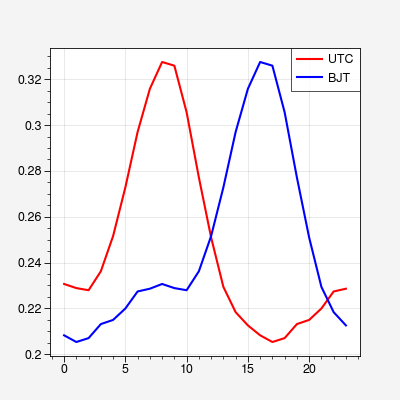

In [9]:
plt.plot(ts_regional[season]['cmorph'][region].values, color = 'r',label = 'UTC')
plt.plot(ts_regional[season]['cmorph'][region].sel(hour = BJT_hourinUTC).values, color = 'b', label = 'BJT')
plt.legend()

In [ ]:
from matplotlib.font_manager import FontProperties

fig, axs = pplt.subplots(ncols=3 ,nrows=4, share=1)

UTC_hour = pd.date_range("1998-04-01T00:00:00","1998-04-01T23:00:00", freq = 'H')

plot_ind = 0
for season in ['am', 'jja']:
        for region in ["NE", "NC", "NWC", "SC",'SW','YZ']:
                model  = 'cmorph'
                plot_var  = ts_regional[season][model][region].sel(hour = BJT_hourinUTC).values
                obs_plot  = axs[plot_ind].plot(UTC_hour, plot_var, color = 'k', label = 'CMORPH', lw = 2.)
                model  = 'vr'
                plot_rainc  = ts_regional[season][model][region].sel(hour = BJT_hourinUTC)['rainc']
                plot_rainnc  = ts_regional[season][model][region].sel(hour = BJT_hourinUTC)['rainnc']
                plot_var = plot_rainc.values + plot_rainnc.values
                vr_plot  = axs[plot_ind].plot(UTC_hour, plot_var, color = 'r', label = 'VR')
                # obs_plot  = axs[plot_ind].plot(UTC_hour, plot_rainc, color = 'r', label = 'VR', linestyle = "dashdot")
                # obs_plot  = axs[plot_ind].plot(UTC_hour, plot_rainnc, color = 'r', label = 'VR', linestyle = "--")
                model  = 'rcm'
                plot_rainc  = ts_regional[season][model][region].sel(hour = BJT_hourinUTC)['rainc']
                plot_rainnc  = ts_regional[season][model][region].sel(hour = BJT_hourinUTC)['rainnc']
                plot_var = plot_rainc.values + plot_rainnc.values
                rcm_plot  = axs[plot_ind].plot(UTC_hour, plot_var, color = 'b', label = 'RCM')
                # obs_plot  = axs[plot_ind].plot(UTC_hour, plot_rainc, color = 'b', label = 'RCM', linestyle = "dashdot")
                # obs_plot  = axs[plot_ind].plot(UTC_hour, plot_rainnc, color = 'b', label = 'RCM', linestyle = "--")
                axs[plot_ind].format(title = region, titleloc = 'uc')


                # ----- add table on axis -----
                # 参考回答：https://stackoverflow.com/questions/54150557/how-to-show-dataframe-index-name-on-a-matplotlib-table
                # 使用bbox调整表格的大小
                plot_table = metrics_ts[season][region]
                table = axs[plot_ind].table(cellText=np.matrix.round(plot_table.values.astype('float'),3),\
                rowLabels=["$\\bf{VR}$","$\\bf{RCM}$"], colLabels=plot_table.columns, loc = 'upper left',colColours=['gainsboro'] * 3,\
                colWidths = [0.13]*3, bbox = [0.1, 0., 0.35, 0.15])
                # table.set_fontweight('roman')
                #  colColours=['gainsboro'] * len(plot_table), colLabels=plot_table.columns, loc='center',
                #  colWidths= [0.12]*(len(plot_table.columns)))
                for (row, col), cell in table.get_celld().items():
                        if ((row == 0)):
                                cell.set_text_props(fontproperties=FontProperties(weight='bold'))

                plot_ind = plot_ind + 1

# ----- limit setting ----- #
# ----- NE & NC  ----- #
axs[0, 0:2].format(ylim = (0.0,0.1))
axs[2, 0:2].format(ylim = (0.05,0.25))
# ----- NWC      ----- #
axs[0, 2].format(ylim = (0.0,0.05))
axs[2, 2].format(ylim = (0.0,0.07))
# ----- SC SW YZ ----- #
axs[1, 0:3].format(ylim = (0.0,0.35))
axs[3, 0:3].format(ylim = (0.1,0.55))


axs[0:2,:].format(ltitle = 'AM')
axs[2:4,:].format(ltitle = 'JJA')                
axs.format(
        abc = True,
        abcloc = 'ul',
# ----- title format       -----
        suptitle = 'diurnal precipitation [mm/hr]',
        xlabel  = 'hour [local time]',
        # leftlabels=('AM', 'AM','JJA', 'JJA'),
# ----- time ticks setting -----
        xlim=(np.datetime64('1998-04-01T00:00:00'), np.datetime64('1998-04-01T23:00:00')),
        xrotation = False,
        xgrid = True,
        xgridminor = True,
        ygridminor = True,
        xminorlocator=('hour',range(0,24,1)),
        xlocator=('hour',range(0,24,3)),
        xformatter = '%H', #title='Ticks every N units',
)

# ----- add legend -----
axs[3,2].legend([obs_plot,vr_plot,rcm_plot], loc='ur', ncols=1, frame=False)

In [ ]:
# saving figs
fig.savefig("./output_pic/hourlypre_ts_6region_12.27.png", dpi = 600, facecolor = "white")